# Sentiment Analysis and Emote Detection of YouTube Data

## Loading data into notebook

In [ ]:
import pandas as pd
pd.options.display.max_colwidth = 500 

#reading data in

youtube_data = pd.read_csv('https://raw.githubusercontent.com/JefNtungila/Sentiment-Analysis-of-Usernames-and-Titles-on-YouTube-and-Twitch/main/data/youtube_data.csv')

In [ ]:
youtube_data.describe(include = 'all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Unnamed: 0,11783,NaN,NaN,NaN,5891,3401.6,0,2945.5,5891,8836.5,11782
reference_index,11783,NaN,NaN,NaN,23.6104,13.9866,0,12,24,36,49
username,11783,1303,America's Got Talent,202,NaN,NaN,NaN,NaN,NaN,NaN,NaN
video_title,11783,1910,Ed Sheeran - Bad Habits [Official Video],74,NaN,NaN,NaN,NaN,NaN,NaN,NaN
publish_time,11783,1878,2021-06-25T04:00:33Z,74,NaN,NaN,NaN,NaN,NaN,NaN,NaN
view_count,11783,NaN,NaN,NaN,7.98687e+06,1.60045e+07,65009,1.03288e+06,2.54451e+06,6.96942e+06,1.50066e+08
comment_count,11783,NaN,NaN,NaN,23365.9,87742.1,0,2500,6386,16928,1.1064e+06
like_count,11783,NaN,NaN,NaN,351735,633044,589,46449,124633,360195,7.42521e+06
dislike count,11783,NaN,NaN,NaN,10204.1,23490.7,17,722.5,2002,7422,252543
api_call_time,11783,245,2021-06-01T08:37:07.564092,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
youtube_data.columns.values

array(['Unnamed: 0', 'reference_index', 'username', 'video_title',
       'publish_time', 'view_count', 'comment_count', 'like_count',
       'dislike count', 'api_call_time', 'date_api_call_time',
       'hour_api_call_time', 'tokenised_title',
       'tokenised_titles_with_stopwords', 'genre', 'words_in_names'],
      dtype=object)

## Wrangling Data into required format for analysis

In [ ]:
#keep title with min amount of videos i.e first time video appear on the youtube trending tab

youtube_min_views = youtube_data.drop_duplicates(subset=['publish_time','username','video_title'], 
                                                 keep='first')[['publish_time', 'date_api_call_time', 'username','video_title', 'tokenised_title',
                                                                'genre', 'words_in_names', 'view_count']]

#keep last title that appears on the youtube trending tab i.e. youtube video with most views
youtube_max_views = youtube_data.drop_duplicates(subset=['publish_time','username','video_title'], 
                                                 keep='last')[['publish_time','username','video_title','view_count', 'date_api_call_time']]

#merging both min and max views dataframe and then renaming columns
youtube_views = pd.merge(youtube_min_views, youtube_max_views, how = 'left', on = ['publish_time','username','video_title'])
youtube_views = youtube_views.rename(columns = {'view_count_x': 'min_views',
                                'view_count_y': 'max_views',
                                'date_api_call_time_x' : 'entry_date',
                                'date_api_call_time_y':'exit_date'})   

#calculating the percentage increase                                                           
view_increase = youtube_views['max_views'] - youtube_views['min_views'] 
percentage_view_increase = view_increase/youtube_views['min_views'] 

youtube_views['percentage_view_increase'] = percentage_view_increase 

#VALIDITY , bots removed observations that decreased or had no increase in viewership
youtube_views = youtube_views[youtube_views['percentage_view_increase'] > 0]

## Performing Sentiment Anaysis on Twitch Data using Vader and Emote-controlled



Vader reference:

Hutto, C. and Gilbert, E., 2014, May. Vader: A parsimonious rule-based model for sentiment analysis of social media text. In Proceedings of the International AAAI Conference on Web and Social Media (Vol. 8, No. 1).




In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
#downloading vader lexincon but what is vader lexicon???????
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


True

In [ ]:
def sentiment_analyser(doc):
#making long string from each token
  # doc = ' '.join(word for word in doc) 
  sid = SentimentIntensityAnalyzer()
  output = sid.polarity_scores(doc)
  sentiment = output['compound']
  return sentiment

youtube_views['sentiment'] = youtube_views['video_title'].apply(lambda x: sentiment_analyser(str(x)))

## Nominal Realism Extraction from Social Media Usernames using Afinn

Afinn reference:

Nielsen, F.Å., 2011. A new ANEW: Evaluation of a word list for sentiment analysis in microblogs. arXiv preprint arXiv:1103.2903.

In [ ]:
!pip install afinn

     |████████████████████████████████| 52 kB 1.2 MB/s 
  Created wheel for afinn: filename=afinn-0.1-py3-none-any.whl size=53447 sha256=58c63f13c6243931152b3a17007fa675334b2d0e1ad9d633b93e02790ac128d0
  Stored in directory: /root/.cache/pip/wheels/9d/16/3a/9f0953027434eab5dadf3f33ab3298fa95afa8292fcf7aba75
Successfully built afinn


In [ ]:
from afinn import Afinn

def name_sentiment_analyser(name):
#making long string from each token
  try:
    #finding words in string of list of words
    #bypassing string datatype and reading it as list with 'eval'
    doc = eval(name)
    #initiating affinity lexicon
    afinn = Afinn(emoticons=True)
    #finding word with largest absolute polarity in name
    score = max([afinn.score(word) for word in doc], key=abs)
    return score
    #error handeling of NaN values
  except:
    pass

In [ ]:
#extracting nominal realism from words
 

youtube_views['name_sentiment'] = youtube_views['words_in_names'].apply(lambda x: name_sentiment_analyser(x))


## Labelling polarity of usernames and titles

In [ ]:
youtube_views['sentiment'] = youtube_views['sentiment'].fillna(0)
youtube_views['name_sentiment'] = youtube_views['name_sentiment'].fillna(0)

In [ ]:
def polarity_detector(score):
  if score < 0:
    return 'negative'
  elif score > 0:
    return 'positive'
  else:
    return 'neutral'

In [ ]:
#labelling username and name polarity

youtube_views['sentiment_polarity'] = youtube_views['sentiment'].apply(lambda x: polarity_detector(x))
youtube_views['name_sentiment_polarity'] = youtube_views['name_sentiment'].apply(lambda x: polarity_detector(x))

## Emotion Detection in titles using NRCLex

Mohammad, S.M. and Turney, P.D., 2013. Nrc emotion lexicon. National Research Council, Canada, 2.

In [ ]:
!pip install NRCLex

     |████████████████████████████████| 396 kB 9.0 MB/s 
  Created wheel for NRCLex: filename=NRCLex-3.0.0-py3-none-any.whl size=43328 sha256=6767236d087e4439c8aa6a191e5eb7c78a5ad3d7b3d0be9082a515b2e9f6d474
  Stored in directory: /root/.cache/pip/wheels/af/2c/9c/dfa19d1b65326c520b32850a9311f6d4eda679ac04dba26081
Successfully built NRCLex


In [ ]:
!python -m textblob.download_corpora

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
Finished.


In [ ]:
from nrclex import NRCLex

def emotion_detector(doc):
  ''' detects emotion in each word of a title using NRCLex'''

  try:
    #detecting emotion for each word
    doc = eval(doc)
    all_emotions  = [NRCLex(i).affect_frequencies for i in doc]
    #formatting all the different emorion dictionarus as dataframes
    all_emotions = [pd.DataFrame(df, index=[i]) for i, df in enumerate(all_emotions)]
    #getting max emotion from words
    all_emotions = dict(pd.concat(all_emotions).max())
    return all_emotions 
  except:
    pass


In [ ]:
youtube_views.columns.values

array(['publish_time', 'entry_date', 'username', 'video_title', 'genre',
       'words_in_names', 'min_views', 'max_views', 'exit_date',
       'percentage_view_increase', 'sentiment', 'name_sentiment'],
      dtype=object)

In [ ]:
#computing emotion detection using NRCLex on titles
 

youtube_views['emotion'] = youtube_views['tokenised_title'].apply(lambda x: emotion_detector(x))

In [ ]:
youtube_views['genre'].unique()

array(['Traditional Media', 'Youtuber', 'Music', 'Trailer', 'Commercial'],
      dtype=object)

In [ ]:
df = youtube_views[youtube_views['genre'] == 'Music']

In [ ]:
emotion_list = []

#preprocessing emotion list to handle potential errors
for i in youtube_views['emotion'].tolist():
  try:
    i = eval(i)
    emotion_list.append(i)
  except:
    continue

#formatting all the emotion dictionaries as dataframes
df_emotions_holder = [pd.DataFrame(df, index=[i]) for i, df in enumerate(emotion_list)]
#cocatenating all the mini dataframes
emotions = pd.concat(df_emotions_holder)

In [ ]:
import numpy as np
#filling na values in anticipation column with 0
emotions_plutchik = emotions.fillna(0)
emotions_plutchik = emotions_plutchik.replace({0:np.nan, 0:np.nan})
# #dropping columns of emotions not analysied
emotions_plutchik = emotions_plutchik.drop(columns=['anticip', 'positive', 'negative'])

In [ ]:
#This scale factor is defined as the total number of observations divided by the number of times a unique emotion is detected.

#1451/ len(emotions_plutchik_scaled[emotions_plutchik_scaled['disgust'].notna()]['disgust']) * emotions_plutchik['disgust'].mean()

0.2754155730533683

## Creating Plutchik Wheel of detected Emotions

Semeraro, A., Vilella, S. and Ruffo, G., 2021. PyPlutchik: visualising and comparing emotion-annotated corpora. arXiv preprint arXiv:2105.04295.

In [ ]:
!pip install pyplutchik

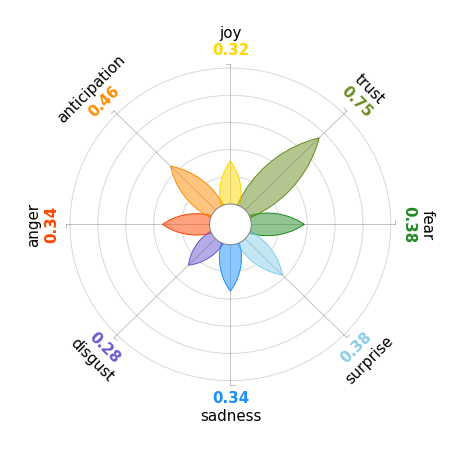

In [ ]:
from pyplutchik import plutchik
import matplotlib.pyplot as plt
from random import uniform

#Must be one of 'joy', 'trust', 'fear', 'surprise', 'sadness', 'disgust', 'anger', 'anticipation'


plutchik(dict(emotions_plutchik.mean()))

# Analysing influence of sentiment on viewership performance

### Reading in data to not have to rerun sentiment analysis code

In [1]:
import pandas as pd

youtube_views = pd.read_csv('https://raw.githubusercontent.com/JefNtungila/Sentiment-Analysis-of-Usernames-and-Titles-on-YouTube-and-Twitch/main/data/youtube_views.csv')
#dropping few values for which no emotion was returned
youtube_views = youtube_views[youtube_views['emotion'].notna()]
#converting percentage increase to values to actual scale
youtube_views['percentage_increase'] = round(youtube_views['percentage_view_increase']*100)

## Producing percentage valence polarity per genre

In [8]:
#percentage polarity per genre 
youtube_views[youtube_views['genre'] == 'Trailer']['name_sentiment_polarity'].value_counts(normalize = True)

neutral     0.724138
negative    0.241379
positive    0.034483
Name: name_sentiment_polarity, dtype: float64

In [9]:
#percentage polarity per genre 
youtube_views[youtube_views['genre'] == 'Commercial']['name_sentiment_polarity'].value_counts(normalize = True)

neutral     0.807692
negative    0.134615
positive    0.057692
Name: name_sentiment_polarity, dtype: float64

In [10]:
#percentage polarity per genre 
youtube_views[youtube_views['genre'] == 'Music']['name_sentiment_polarity'].value_counts(normalize = True)

neutral     0.693069
positive    0.168317
negative    0.138614
Name: name_sentiment_polarity, dtype: float64

In [11]:
#percentage polarity per genre 
youtube_views[youtube_views['genre'] == 'Traditional Media']['name_sentiment_polarity'].value_counts(normalize = True)

neutral     0.768061
positive    0.182510
negative    0.049430
Name: name_sentiment_polarity, dtype: float64

In [12]:
#percentage polarity per genre 
youtube_views[youtube_views['genre'] == 'Youtuber']['name_sentiment_polarity'].value_counts(normalize = True)

neutral     0.754696
positive    0.156906
negative    0.088398
Name: name_sentiment_polarity, dtype: float64

## Analysing boxplots of percentage increase viewership per genre

Text(0.5, 1.0, 'Effect of Sentiment on Viewership Increase - YouTube')

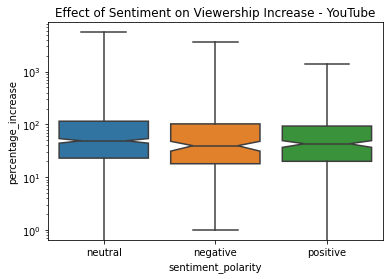

In [29]:
import seaborn as sns

#investigating the influence of sentiment on viewership performance

boxplot1 = sns.boxplot(x='sentiment_polarity', y='percentage_increase', 
                  data=youtube_views, whis=[0, 100], notch = True)
boxplot1.set(yscale='log')
boxplot1.set_title('Effect of Sentiment on Viewership Increase - YouTube')

Text(0.5, 1.0, 'Effect of Name Sentiment on Viewership Increase - YouTube')

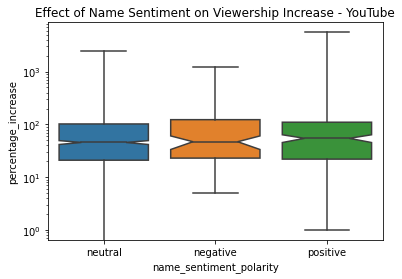

In [30]:
import seaborn as sns

boxplot2 = sns.boxplot(x='name_sentiment_polarity', y='percentage_increase', 
                  data=youtube_views, whis=[0, 100], notch = True)
boxplot2.set(yscale='log')
boxplot2.set_title('Effect of Name Sentiment on Viewership Increase - YouTube')

In [15]:
def emotion_aggregator(emotion):
  '''
  function takes in emotion dictionary 
  and returns biggest value of emotion detected in series
  '''
  emotion = eval(emotion)
  del emotion['negative']
  del emotion['positive']
  del emotion['anticip']
  emotion = max(emotion, key=emotion.get)
  return emotion

In [16]:
#computing strongest emotion 
youtube_views['strongest_emotion'] = youtube_views['emotion'].apply(lambda x: emotion_aggregator(x))

Text(0.5, 1.0, 'Effect of Emotion on Viewership Increase - YouTube')

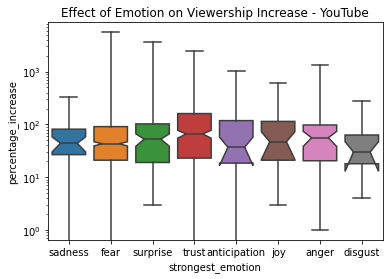

In [17]:

#investigating influence of emotion on viewership performance



boxplot3 = sns.boxplot(x='strongest_emotion', y='percentage_increase', 
                  data=youtube_views, whis=[0, 100], notch = True)
boxplot3.set(yscale='log')
boxplot3.set_title('Effect of Emotion on Viewership Increase - YouTube')

## Computing median percentage increase in viewership and confidence interval of the point estimate

In [18]:
import numpy as np
import scipy.stats as st

def confidence_calc(data): 
  '''function takes a series in, computes the median
   and then gives 95% confindece interval of the median'''
  a,b = st.t.interval(alpha=0.95, df=len(data)-1, loc=np.median(data), scale=st.sem(data))
  return (round(a), round(b))




In [19]:
youtube_views.groupby('sentiment_polarity').median()['percentage_increase']

sentiment_polarity
negative    39.5
neutral     49.0
positive    43.0
Name: percentage_increase, dtype: float64

In [20]:
#computing 95% confidence interval for youtube views
print(confidence_calc(youtube_views[youtube_views['sentiment_polarity']=='negative']['percentage_increase']))
print(confidence_calc(youtube_views[youtube_views['sentiment_polarity']=='neutral']['percentage_increase']))
print(confidence_calc(youtube_views[youtube_views['sentiment_polarity']=='positive']['percentage_increase']))

(2, 77)
(31, 67)
(26, 60)


In [21]:
youtube_views.groupby('name_sentiment_polarity').median()['percentage_increase']

name_sentiment_polarity
negative    47.0
neutral     45.5
positive    54.5
Name: percentage_increase, dtype: float64

In [22]:
#computing confidence interval of median values
print(confidence_calc(youtube_views[youtube_views['name_sentiment_polarity']=='negative']['percentage_increase']))
print(confidence_calc(youtube_views[youtube_views['name_sentiment_polarity']=='neutral']['percentage_increase']))
print(confidence_calc(youtube_views[youtube_views['name_sentiment_polarity']=='positive']['percentage_increase']))

(12, 82)
(35, 56)
(-8, 117)


In [23]:
youtube_views.groupby('strongest_emotion').median()['percentage_increase']

strongest_emotion
anger           56.0
anticipation    37.0
disgust         30.0
fear            43.0
joy             47.0
sadness         44.0
surprise        52.5
trust           66.0
Name: percentage_increase, dtype: float64

In [24]:
#producing confidence interval for effect of different emotions on viewership

print(confidence_calc(youtube_views[youtube_views['strongest_emotion']=='sadness']['percentage_increase']))
print(confidence_calc(youtube_views[youtube_views['strongest_emotion']=='fear']['percentage_increase']))
print(confidence_calc(youtube_views[youtube_views['strongest_emotion']=='surprise']['percentage_increase']))

print(confidence_calc(youtube_views[youtube_views['strongest_emotion']=='trust']['percentage_increase']))
print(confidence_calc(youtube_views[youtube_views['strongest_emotion']=='anticipation']['percentage_increase']))
print(confidence_calc(youtube_views[youtube_views['strongest_emotion']=='joy']['percentage_increase']))


print(confidence_calc(youtube_views[youtube_views['strongest_emotion']=='anger']['percentage_increase']))
print(confidence_calc(youtube_views[youtube_views['strongest_emotion']=='disgust']['percentage_increase']))




(22, 66)
(26, 60)
(-32, 137)
(38, 94)
(-7, 81)
(1, 93)
(-7, 119)
(-4, 64)


## Computing Ranked ANOVA to understand significance in difference in ranked median

In [25]:
#computing ranked ANOVA  for youtube views
x = youtube_views[youtube_views['sentiment_polarity']=='negative']['percentage_increase']
y = youtube_views[youtube_views['sentiment_polarity']=='neutral']['percentage_increase']
z = youtube_views[youtube_views['sentiment_polarity']=='positive']['percentage_increase']
st.kruskal(x, y, z)



KruskalResult(statistic=6.764697890369805, pvalue=0.033967572985396634)

In [26]:
#computing ranked ANOVA for youtube views
x = youtube_views[youtube_views['name_sentiment_polarity']=='negative']['percentage_increase']
y = youtube_views[youtube_views['name_sentiment_polarity']=='neutral']['percentage_increase']
z = youtube_views[youtube_views['name_sentiment_polarity']=='positive']['percentage_increase']
st.kruskal(x, y, z)


KruskalResult(statistic=2.276301178074153, pvalue=0.32041104590057595)

In [27]:
#computing ranked ANOVA for twitch views

x = youtube_views[youtube_views['strongest_emotion']=='sadness']['percentage_increase']
y = youtube_views[youtube_views['strongest_emotion']=='fear']['percentage_increase']
z = youtube_views[youtube_views['strongest_emotion']=='surprise']['percentage_increase']

a = youtube_views[youtube_views['strongest_emotion']=='trust']['percentage_increase']
b = youtube_views[youtube_views['strongest_emotion']=='anticipation']['percentage_increase']
c = youtube_views[youtube_views['strongest_emotion']=='joy']['percentage_increase']


d = youtube_views[youtube_views['strongest_emotion']=='anger']['percentage_increase']
e = youtube_views[youtube_views['strongest_emotion']=='disgust']['percentage_increase']

st.kruskal(x, y, z, a, b, c, d, e)

KruskalResult(statistic=24.4435577573094, pvalue=0.000951792657759966)